<h3>Mapping Short-term Ocean Shoreline Change in North Carolina - 2004 to 2014 Nags Head Study Site</h3>

**The Data:**

- The North Carolina Department of Environmental Quality: https://deq.nc.gov/about/divisions/coastal-management/coastal-management-data/spatial-data-maps provided shorelines for 1933-1952, 1940-1962, 1998, 2004, and 2009. Shore-normal transects were also acquired from the DEQ DCM.


- The U.S. Geological Survey: https://pubs.usgs.gov/of/2005/1326/gis-data.html as part of The National Assessment on Shoreline Change: A GIS Compilation of Vector Shorelines and Associated Shoreline Change Data for the U.S. Southeast Atlantic Coast (Miller, Morton, Sallenger, USGS Open File Report 2005-1326). This group provided shorelines captured between 1849 and 1997, along with shoreline-normal transects (interval=50m) and baseline (offshore).


- LiDAR data was obtained from: https://coast.noaa.gov/dataregistry/search/collection/info/coastallidar or, if you want the interactive viewer: https://coast.noaa.gov/dataviewer/#/lidar/search/ These data will be used to generate/derive more contemporary (post 1997) study site shorelines as a test case for he Town of Nags Head, NC. 


- Long-Term Ocean shoreline erosion data is from: 
The North Carolina Department of Environmental Quality: https://deq.nc.gov/about/divisions/coastal-management/coastal-management-data/spatial-data-maps. The Department last updated ocean shoreline rates in 2013, using a 2011 shoreline.
Erosion rates for 2013 are computed using the Endpoint Rate Method. 


NOTES:
1. transects from the NC DEQ/DCM report erosion rates as follows:
    EPR_M = End Point Rate in meters
    EPR_2009_S = End Point Rate computed in 2009 in U.S. Survey feet, smoothed
    EPR_2009_R = End Point Rate computed in 2009 in U.S. Survey feet, raw
    
    
2. LiDAR shorelines are only used in a prototype case for the Town of Nags Head. All subsequent analyses, including those which contribute to and all final report(s), use shorelines supplied by the NC DEQ/DCM.

<h4>Geography:</h4>

Site 1:  The Town of Nags Head, NC. From the SE end to just north of Jennette's Pier:

![nags_nead](../misc/Nags_Head_Study_Area.png)

The Nags Head study area. LiDAR DEM data from 2004, 2005, 2009, 2012, and 2014 were retrieved from the source listing for LiDAR, in the prior cell. EPSG: 3632 (NAD83(NSRS2007)/North Carolina (ftUS)

<h4>Processing:</h4> **Part 1  (Extracting MHW shorelines from the LiDAR-derived DEMs)**

NOTE: These shorelines apply only to the Nags Head prototype. 

- Create a mask area that restricts processing to area along subaerial beach. Digitize mask polygon in QGIS using the 2004 and 2014 DEMs for guidance. The interior boundary follows the approximate centerline of State Route 1243. 

Working in QGIS:
- create a temporary raster mask using the GRASS Toolbox Command r.mask.vect using the current DEM. This will, in essence, clip out a portion of the underlying DEM creating an autonomous DEM subset called MASK.


- Generate 100000 random points, confining the generation area to the geographic extents of the MASK, using r.random from the GRASS Toolbox. The DEM values (elevations above or below the NAVD88 shoreline) are automataically conflated tothe random points upon creation.


- Select from the random point set that subset which meets the critera: 1.90 <= z <= 2.10 (in QGIS, Select Features by Expression). Save these points to a new (and permanent) shape file (naming convention: <loc>_SLxy, example: NH_SLxy for the Town of Nags Head (NH), North Carolina).


NOTE: the selection of points between 1.9 and 2.1 feet above the 0 foot shoreline is a result of the offset between the NAVD88 0 feet contour and MHW--which is the datum used in this analysis. The difference along this section of the Northeastern North Carolina coastline is about 0.6 meters or 1.97 feet. The span from 1.9 to 2.1 feet provides the desired translation of the shoreline from NAVD88 to MHW.


- Using QGIS's digitizing tools edit to remove 'extraneous' points in the resulting point subset shape file. Note that it's not unusual for there to be points that meet the selection criteria that sit back off the beach. 


- Again, using QGIS's digitizing tools, this time create a new line shape file and connect the shoreline 'dots' to create a vector shoreline for analysis. Save and save often. 


- Clean up: remove the MASK and temporary random vector layers

<h4>Processing:</h4> **Part 2  (Generate the shoreline/transect crossings (intersections) for each shoreline vintage)**

This process intersects each shoreline vintage with the transects. The result is a set of points marking the intersection location of the shoreline vector with each transect that it (the shoreline) crosses. The locations of these intersections (points) will be used in the next processing step to compute the shoreline displacement and displacement rate.

In QGIS:
- Vector --> Analysis Tools --> Line Intersections
    - input: shoreline vector (line)
    - intersect layer: transects
    - input unique id: year
    - intersect unqiue id: ID
    - export the intersection results to an external ASCII comma separated text file
    
    
Do this for each of the shorelines in the analysis. 

<h4>Processing:</h4> **Part 3  (Processing the shoreline positions and displacements,  and plotting the results)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [20]:
### SIDEBAR: check for a unique transect ID:

fpath='/Volumes/Beaker/projects/nc_coastal_erosion/data/DCM_transects_oceanfront_50meter/'

df_ = pd.read_csv(fpath+'transects_oceanfront_50meter.csv')
#df_.duplicated('NCDCM_ID')

names = df_.NCDCM_ID.value_counts()
names[names > 1]



Series([], Name: NCDCM_ID, dtype: int64)

Mean EPR: -1.5617051214  Median EPR: -1.3124
EPR Standard Deviation: 5.08233032745


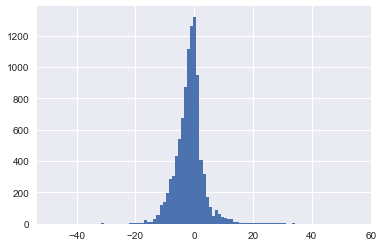

In [34]:
## SIDEBAR: generate a histogram and a few simple statistics for the end point erosion rates reported from the 
# 2009 data:

b=int(9802**0.5)    # nothing fancy to get the bin count, just the simple square root rule...
df_['EPR_2009_R'].hist(bins=b) 

print('Mean EPR:', df_['EPR_2009_R'].mean(), ' Median EPR:', df_['EPR_2009_R'].median())
print('EPR Standard Deviation:', df_['EPR_2009_R'].std())

In [33]:
# import each of the five transect/shoreline intersections files into individual (for the moment) pandas dataframes:
# apply an n-observation moving average to smooth the shoreline. North Carolina uses a 17 observation moving average,
# however, this is taken across all of the 300-plus mile, almost 9000 transected coastline. Within the confined space 
# of the Nags Head study site this might require some scaling so that not too much data is lost in the process...

fpath='/Volumes/Beaker/projects/nc_coastal_erosion/data/decadal_shorelines/intersections/'
f_2004='NH_Intersections_2004.csv'
f_2005='NH_Intersections_2005.csv'
f_2009='NH_Intersections_2009.csv'
f_2012='NH_Intersections_2012.csv'
f_2014='NH_Intersections_2014.csv'

# x,y,year,transect
cols=['x_04','y_04','year', 'transect']
df_2004 = pd.read_csv(fpath+f_2004, header=0, names=cols )

cols=['x_05','y_05','year', 'transect']
df_2005 = pd.read_csv(fpath+f_2005, header=0, names=cols )

cols=['x_09','y_09','year', 'transect']
df_2009 = pd.read_csv(fpath+f_2009, header=0, names=cols )

cols=['x_12','y_12','year', 'transect']
df_2012 = pd.read_csv(fpath+f_2012, header=0, names=cols )

cols=['x_14','y_14','year', 'transect']
df_2014 = pd.read_csv(fpath+f_2014, header=0, names=cols )

In [26]:
### import the transects themselves to retrieve the EPR values:
fpath='/Volumes/Beaker/projects/nc_coastal_erosion/data/decadal_shorelines/'
f_transects='NH_transects.csv'

cols=['ID','BASELNID','TIMESTMP','AUTOGEN','STARTX','STARTY','ENDX','ENDY','AZIMUTH','POINTCNT','EPR']

df_transects=pd.read_csv(fpath+f_transects, header=0, names=cols)
df_transects['EPRm']=df_transects.EPR*3.2801

df_2004.describe()

,x_04,y_04,year,transect
count,1.560000e+02,156.000000,156.0,156.000000
mean,3.013401e+06,791814.025152,2004.0,8185.500000
std,3.139376e+03,6697.872203,0.0,45.177428
min,3.007949e+06,780181.230953,2004.0,8108.000000
25%,3.010703e+06,786105.388437,2004.0,8146.750000
50%,3.013469e+06,791870.703442,2004.0,8185.500000
75%,3.016147e+06,797501.777303,2004.0,8224.250000
max,3.018584e+06,803284.148896,2004.0,8263.000000


In [34]:
### join (inner join) the shorelines that will be compared (2004-05; 2005-09; 2009-12; 2012-14; 2004-14):

df_0405 = pd.merge(df_2004, df_2005, on='transect', how='inner').sort_values('transect')
df_0509 = pd.merge(df_2005, df_2009, on='transect', how='inner').sort_values('transect')
df_0912 = pd.merge(df_2009, df_2012, on='transect', how='inner').sort_values('transect')
df_1214 = pd.merge(df_2012, df_2014, on='transect', how='inner').sort_values('transect')
df_0414 = pd.merge(df_2004, df_2014, on='transect', how='inner').sort_values('transect')

### go ahead and sort the transects too, for consistency (if for no other reason):
df_transects = df_transects.sort_values('ID')

In [35]:
### compute the shoreline displacement [absolute value] and rate [absolute value] for each comparison:

# for displacement:
df_0405['displ_abs'] = ((df_0405.x_05-df_0405.x_04)**2 + (df_0405.y_05-df_0405.y_04)**2)**0.5
df_0509['displ_abs'] = (((df_0509.x_09-df_0509.x_05)**2 + (df_0509.y_09-df_0509.y_05)**2)**0.5)
df_0912['displ_abs'] = (((df_0912.x_12-df_0912.x_09)**2 + (df_0912.y_12-df_0912.y_09)**2)**0.5)
df_1214['displ_abs'] = (((df_1214.x_14-df_1214.x_12)**2 + (df_1214.y_14-df_1214.y_12)**2)**0.5)
df_0414['displ_abs'] = (((df_0414.x_14-df_0414.x_04)**2 + (df_0414.y_14-df_0414.y_04)**2)**0.5)

# for rate:
df_0405['epr_abs'] = ((df_0405.x_05-df_0405.x_04)**2 + (df_0405.y_05-df_0405.y_04)**2)**0.5
df_0509['epr_abs'] = (((df_0509.x_09-df_0509.x_05)**2 + (df_0509.y_09-df_0509.y_05)**2)**0.5) / 4.0
df_0912['epr_abs'] = (((df_0912.x_12-df_0912.x_09)**2 + (df_0912.y_12-df_0912.y_09)**2)**0.5) / 3.0
df_1214['epr_abs'] = (((df_1214.x_14-df_1214.x_12)**2 + (df_1214.y_14-df_1214.y_12)**2)**0.5) / 2.0
df_0414['epr_abs'] = (((df_0414.x_14-df_0414.x_04)**2 + (df_0414.y_14-df_0414.y_04)**2)**0.5) / 10.0

In [36]:
### function sets the sign for the shoreline change deltas (negative signed if erosion, positive signed if accretion)
# Since the delta (delta_abs) is computed using Euclidean geometry (square root of the sum of the squares) we end
# up with only shoreline displacement magnitude. To recover direction we have to revisit the original differences
# between the shoreline transection intersections.
def ErosionVsAccretion(x1, x2, y):
    if(x2 - x1) < 0:
        return(y * -1.0)
    else:
        return(y)

# for displacement:
df_0405['displ']=df_0405.apply(lambda x: ErosionVsAccretion(x['x_04'], x['x_05'], x['displ_abs'] ), axis=1 )
df_0509['displ']=df_0509.apply(lambda x: ErosionVsAccretion(x['x_05'], x['x_09'], x['displ_abs'] ), axis=1 )
df_0912['displ']=df_0912.apply(lambda x: ErosionVsAccretion(x['x_09'], x['x_12'], x['displ_abs'] ), axis=1 )
df_1214['displ']=df_1214.apply(lambda x: ErosionVsAccretion(x['x_12'], x['x_14'], x['displ_abs'] ), axis=1 )
df_0414['displ']=df_0414.apply(lambda x: ErosionVsAccretion(x['x_04'], x['x_14'], x['displ_abs'] ), axis=1 )


df_0405['epr']=df_0405.apply(lambda x: ErosionVsAccretion(x['x_04'], x['x_05'], x['epr_abs'] ), axis=1 )
df_0509['epr']=df_0509.apply(lambda x: ErosionVsAccretion(x['x_05'], x['x_09'], x['epr_abs'] ), axis=1 )
df_0912['epr']=df_0912.apply(lambda x: ErosionVsAccretion(x['x_09'], x['x_12'], x['epr_abs'] ), axis=1 )
df_1214['epr']=df_1214.apply(lambda x: ErosionVsAccretion(x['x_12'], x['x_14'], x['epr_abs'] ), axis=1 )
df_0414['epr']=df_0414.apply(lambda x: ErosionVsAccretion(x['x_04'], x['x_14'], x['epr_abs'] ), axis=1 )

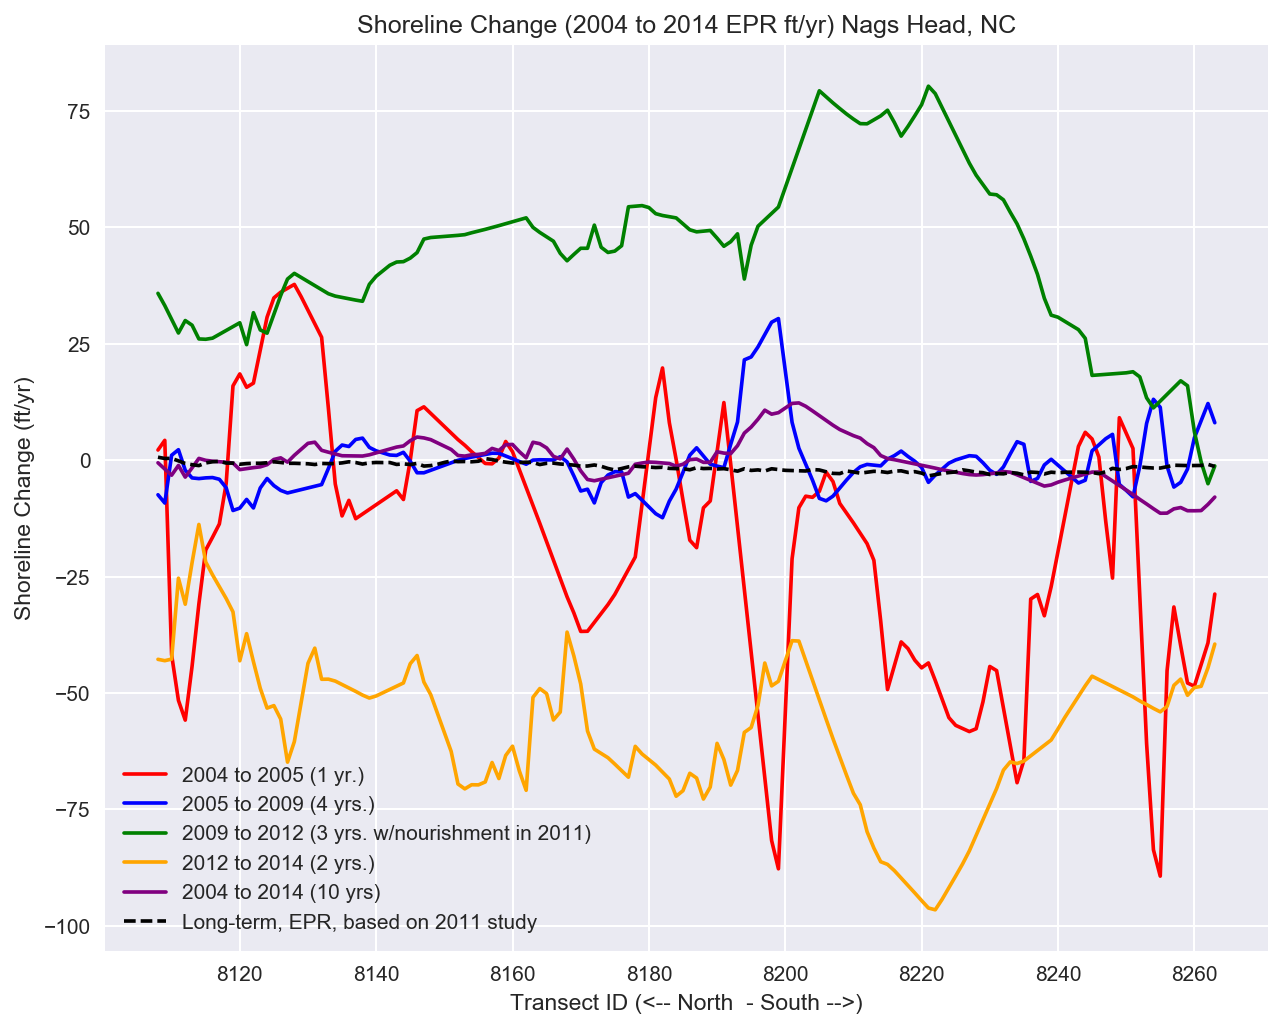

In [43]:
# plot the End Point Rates for the shoreline pairs:

plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')

plt.plot(df_0405.transect, df_0405.epr, c='red', label='2004 to 2005 (1 yr.)')
plt.plot(df_0509.transect, df_0509.epr, c='blue', label='2005 to 2009 (4 yrs.)')
plt.plot(df_0912.transect, df_0912.epr, c='green', label='2009 to 2012 (3 yrs. w/nourishment in 2011)')
plt.plot(df_1214.transect, df_1214.epr, c='orange', label='2012 to 2014 (2 yrs.)')
plt.plot(df_0414.transect, df_0414.epr, c='purple', linestyle='solid', label='2004 to 2014 (10 yrs)')
plt.plot(df_transects.ID, df_transects.EPR, linestyle='dashed', c='k', label='Long-term, EPR, based on 2011 study')
plt.xlabel('Transect ID (<-- North  - South -->)')
plt.ylabel('Shoreline Change (ft/yr)')
plt.title('Shoreline Change (2004 to 2014 EPR ft/yr) Nags Head, NC')
plt.legend(loc='lower left')

plt.savefig('/Volumes/Beaker/projects/nc_coastal_erosion/misc/decade_shoreline_erosionrate_NH.pdf')

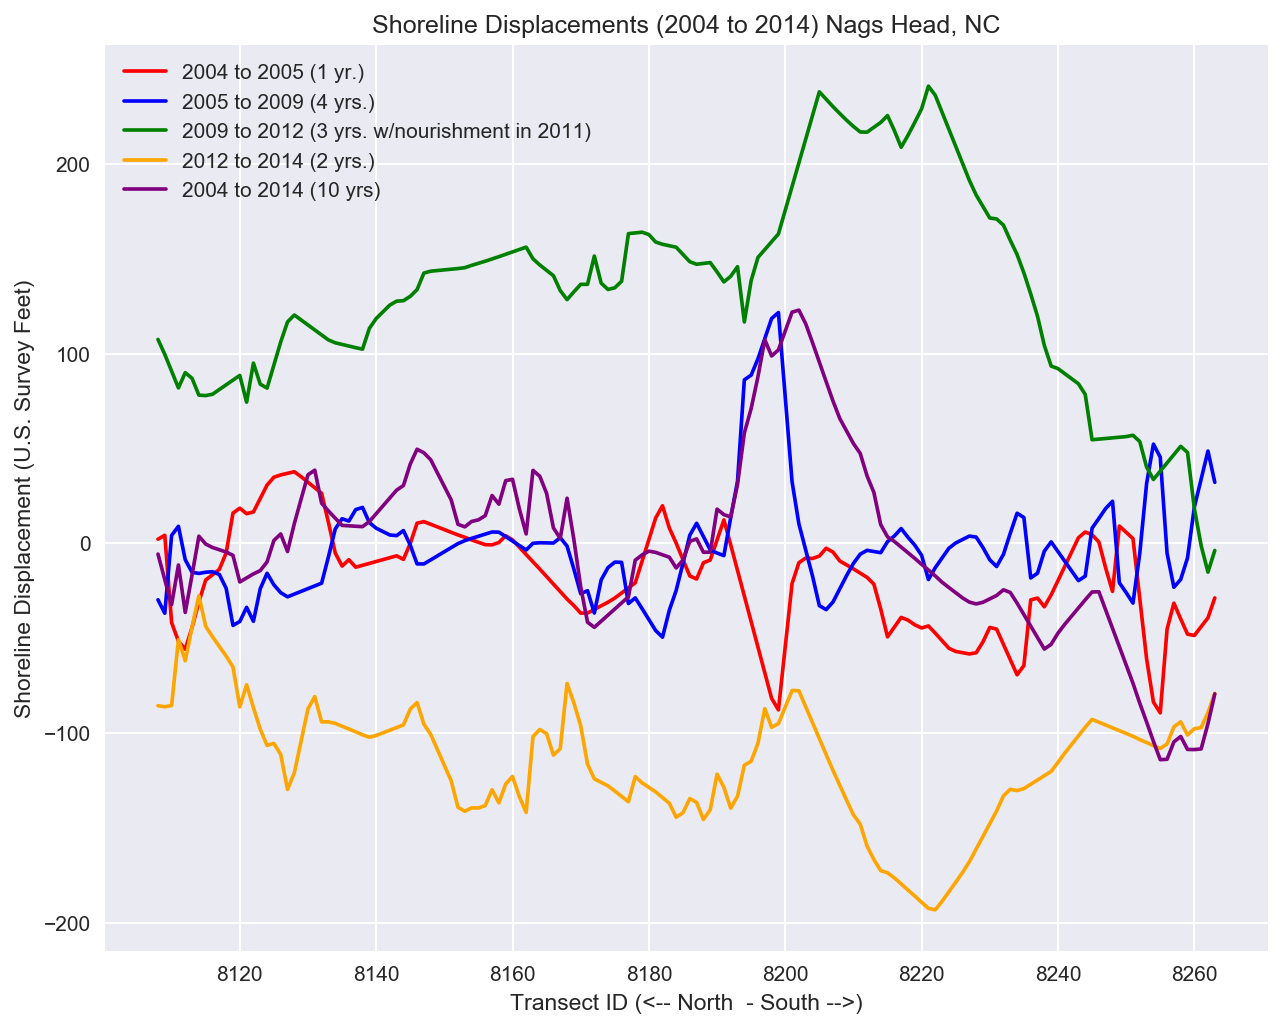

In [45]:
# plot the net displacements for the shoreline pairs:

plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')

plt.plot(df_0405.transect, df_0405.displ, c='red', label='2004 to 2005 (1 yr.)')
plt.plot(df_0509.transect, df_0509.displ, c='blue', label='2005 to 2009 (4 yrs.)')
plt.plot(df_0912.transect, df_0912.displ, c='green', label='2009 to 2012 (3 yrs. w/nourishment in 2011)')
plt.plot(df_1214.transect, df_1214.displ, c='orange', label='2012 to 2014 (2 yrs.)')
plt.plot(df_0414.transect, df_0414.displ, c='purple', linestyle='solid', label='2004 to 2014 (10 yrs)')
#plt.plot(df_transects.ID, df_transects.EPR, linestyle='dashed', c='k', label='Long-term, EPR, based on 2011 study')
plt.xlabel('Transect ID (<-- North  - South -->)')
plt.ylabel('Shoreline Displacement (U.S. Survey Feet)')
plt.title('Shoreline Displacements (2004 to 2014) Nags Head, NC')
plt.legend(loc='upper left')

plt.savefig('/Volumes/Beaker/projects/nc_coastal_erosion/misc/decade_shoreline_displacement_NH.pdf')

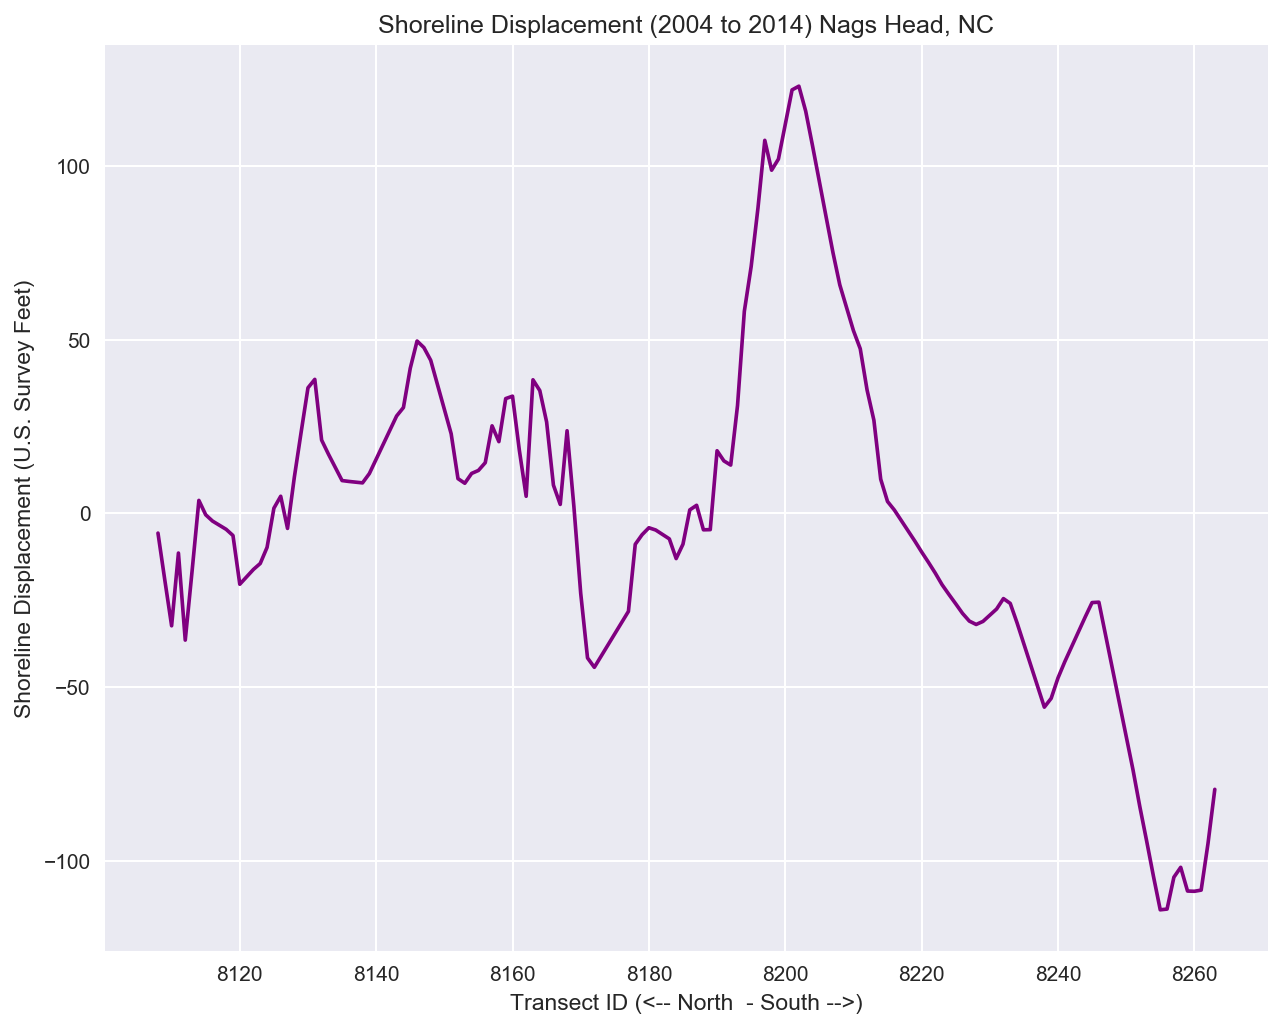

In [48]:
# plot the net decadal displacement alone for the 2004 - 2014 shoreline pair:

plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
plt.plot(df_0414.transect, df_0414.displ, c='purple', linestyle='solid', label='2004 to 2014')
#plt.plot(df_transects.ID, df_transects.EPR, linestyle='dashed', c='k', label='Long-term, EPR, based on 2011 study')
plt.xlabel('Transect ID (<-- North  - South -->)')
plt.ylabel('Shoreline Displacement (U.S. Survey Feet)')
plt.title('Shoreline Displacement (2004 to 2014) Nags Head, NC')
#plt.legend(loc='upper left')

plt.savefig('/Volumes/Beaker/projects/nc_coastal_erosion/misc/decade_shoreline_decadedisplacement_NH.pdf')